จากใน ep ก่อน เราได้เรียนรู้การสร้าง ConvNet ขึ้นมาจากหลายส่วนประกอบด้วยกัน เมื่อสร้างโมเดลขึ้นมาแล้ว ก่อนเทรนเราจำเป็นต้อง [Initialize Parameter](https://www.bualabs.com/archives/1816/example-vanishing-gradient-problem-how-to-fix-vanishing-gradient-kaiming-initialization-neural-network-ep-3/) (Weight, Bias) ต่าง ๆ ด้วยค่าที่เหมาะสม ใน ep ที่แล้ว เราใช้ [Kaiming Initalization](https://www.bualabs.com/archives/1789/what-is-vanishing-gradient-problem-fix-vanishing-gradient-problem-with-xavier-initialization-kaiming-initialization-neural-network-ep-2/)

แล้วถ้าโมเดลเราเกิดซับซ้อนขึ้นเรื่อย ๆ ล่ะ เช่น มีการเปลี่ยน [Activaiton Function](https://www.bualabs.com/archives/1261/what-is-activation-function-what-is-sigmoid-function-activation-function-ep-1/) หรือมี Skip Connection จะทำอย่างไร Kaiming Initialization ก็มี Parameter ให้เรา Config ได้พอสมควร เช่น a=0, gain, mode='fan_in', nonlinearity='leaky_relu', etc. แต่ถ้าโมเดลเราซับซ้อนกว่านั้นอีกล่ะ

Layer-sequential unit-variance Initialization หรือ เรียกสั้น ๆ ว่า LSUV เป็นแนวคิดง่าย ๆ ในการ Intialization ที่ไม่ต้องใช้สูตรคณิตศาสต์ซับซ้อน LSUV มีแนวคิดที่คล้าย ๆ กับ [LR Finder](https://www.bualabs.com/archives/2377/lr-find-best-learning-rate-train-machine-learning-model-deep-neural-network-callback-neural-network-ep-12/) คือ อัพเดท Parameter แล้ววนลูปเช็คไปเรื่อย ๆ จนกว่าจะได้ตามที่ต้องการ เรามาดูตัวอย่างจะเห็นภาพชัดขึ้น LSUV เริ่มที่หัวข้อ [4/2. Init Model wih LSUV](#4/2.-Init-Model-wih-LSUV)

# 0. Magic Commands


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy
import torch.nn.init as init
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

# 2. ข้อมูล

ใช้ชุดข้อมูล Dataset [MNIST](https://www.bualabs.com/archives/2215/what-is-mnist/) ตัวเลขอารบิคเขียนด้วยลายมือ

In [3]:
# ## Small Dataset for quick test
# path = untar_data(URLs.MNIST_SAMPLE)

# Full Dataset
path = untar_data(URLs.MNIST)

path

PosixPath('/root/.fastai/data/mnist_png')

# 3. เตรียมข้อมูล



1. สำหรับข้อมูลประเภทตัวเลข เราไม่สามารถ flip ซ้าย ขวา ขึ้น ลง ได้ จะทำให้ผิดความหมายไป จึงต้องใช้ get_transforms(do_flip=False)
2. เคสนี้ label คือชื่อ Folder ที่บรรจุไฟล์อยู่ เราสามารถ ใช้ ImageDataBunch.from_folder ได้เลย
3. num_workers คือ จำนวน CPU Core ที่ต้องการใช้

In [0]:
batchsize = 64
max_lr = 3e-2
wd = 1e-1
np.random.seed(0)
transform = get_transforms(do_flip=False)

databunch = ImageDataBunch.from_folder(path, train='training', valid_pct=0.2, size=28, 
                                       ds_tfms=transform, bs=batchsize, num_workers=8).normalize()

## สำรวจข้อมูล ##

ลองดูข้อมูล Batch แรก ด้วย show_batch สั่งให้แสดง รูป พร้อม label ไว้บนรูป แสดง 3 แถว (rows) ในกรอบขนาด 10 x 10 นิ้ว (figsize)

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

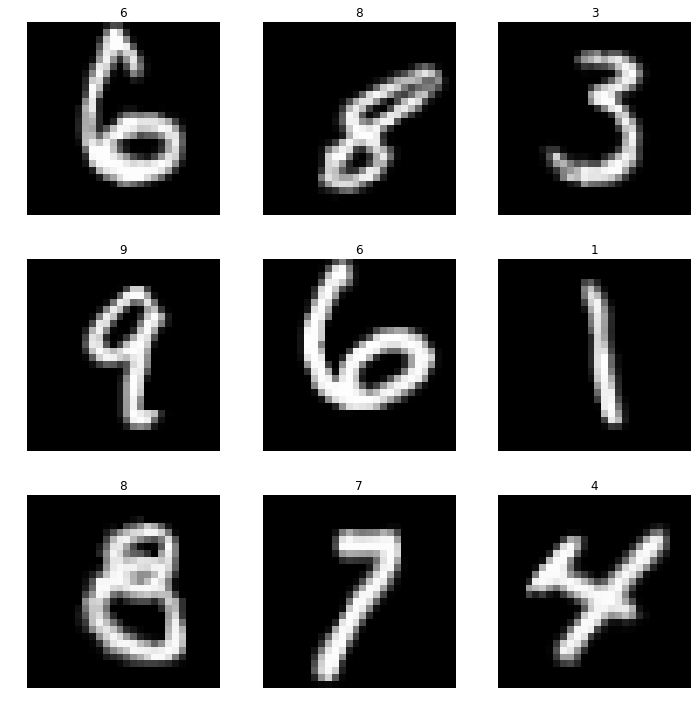

In [5]:
databunch.show_batch(rows=3, figsize=(10, 10))

ดู label ตัวเลขทั้งหมด หรือ class ทั้งหมด ที่มีใน Dataset

In [6]:
databunch.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# 4. สร้างโมเดล

เราจะสร้างโมเดล [Deep Convolutional Neural Network](https://www.bualabs.com/archives/2461/what-is-convolutional-neural-network-cnn-convnet-mnist-deep-learning-convnet-ep-1/) ที่มี 4 ConvLayer และใช้ nn.ReLU ดังด้านล่าง

In [0]:
def get_cnn_model(data, **kwargs):
    return nn.Sequential(
        nn.Conv2d(  3,  8, 5, padding=2, stride=2), nn.ReLU(), #14
        nn.Conv2d(  8, 16, 3, padding=1, stride=2), nn.ReLU(), # 7
        nn.Conv2d( 16, 32, 3, padding=1, stride=2), nn.ReLU(), # 4
        nn.Conv2d( 32, 32, 3, padding=1, stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1), 
        Lambda(flatten), 
        nn.Linear(32, data.c)
    )

# def mnist_resize(x): return x.view(-1, 1, 28, 28)
def flatten(x): return x.view(x.shape[0], -1)    

def init_cnn(m, uniform=False, bias=True):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Conv2d):
            f(l.weight, a=0.)
            if bias: l.bias.data.zero_()

สร้างโมเดล และ Initialize ด้วย [Kaiming Normal](https://www.bualabs.com/archives/1816/example-vanishing-gradient-problem-how-to-fix-vanishing-gradient-kaiming-initialization-neural-network-ep-3/)

In [0]:
model = get_cnn_model(databunch)
init_cnn(model)

ดูโครงสร้างของโมเดล

In [9]:
model

Sequential(
  (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): AdaptiveAvgPool2d(output_size=1)
  (9): Lambda()
  (10): Linear(in_features=32, out_features=10, bias=True)
)

ประกาศฟังก์ชัน [Hook](https://www.bualabs.com/archives/2556/example-pytorch-hook-analysis-mean-standard-deviation-histogram-activation-map-deep-convolutional-neural-network-general-relu-convnet-ep-3/) ต่าง ๆ เอาไว้ดูค่าภายในโมเดล ในหัวข้อถัดไป

In [0]:
def children(m): list(m.children())

class Hook():
    # m = module, f = function
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx): 
        if isinstance(idx, (int, slice)): return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx) == len(self) # boolean mask
            return [o for m, o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self) > 10: res = res[:-1] + '...]'
        return res
        
class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    
    def remove(self):
        for h in self: h.remove()  

สร้าง [Learner](https://www.bualabs.com/archives/2318/databunch-learner-refactor-neural-network-training-loop-neural-network-ep-9/) จาก Model เตรียมเทรน

In [0]:
learner = Learner(databunch, model, metrics=accuracy,callback_fns=ShowGraph)

# 5. Train Model


เทรนไป 1 Epoch

epoch,train_loss,valid_loss,accuracy,time
0,0.111981,0.063807,0.981571,01:32


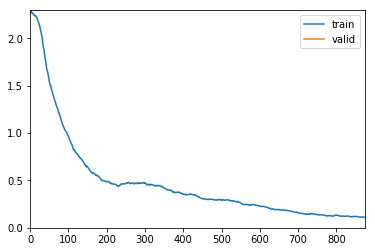

In [12]:
learner.fit_one_cycle(1, max_lr=max_lr, wd=wd)


# 4/2. Init Model wih LSUV

แทนที่เราจะ Init ด้วย Kaiming Normal เราจะใช้การ Initialization แบบ LSUV แทน

## Before

สร้างโมเดลขึ้นมาใหม่

In [13]:
model = get_cnn_model(databunch)
model

Sequential(
  (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): AdaptiveAvgPool2d(output_size=1)
  (9): Lambda()
  (10): Linear(in_features=32, out_features=10, bias=True)
)

ประกาศฟังก์ชัน Recursive หา Module ที่เราต้องการ Init ทั้งหมด ใส่ List ไว้

In [0]:
def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o, cond) for o in m.children()], [])


หา Module Linear, Conv2d ทั้งหมด ที่อยู่ในโมเดล

In [15]:
mods = find_modules(model, lambda o: isinstance(o, (nn.Linear, nn.Conv2d)))
mods

[Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Linear(in_features=32, out_features=10, bias=True)]

แบ่งข้อมูลจาก [DataLoader](https://www.bualabs.com/archives/1994/dataset-dataloader-feed-data-x-y-batch-to-neural-network-refactor-training-loop-neural-network-ep-5/) ใน DataBunch ออกมา 1 [Batch](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/) เตรียมใส่ [GPU](https://www.bualabs.com/archives/1426/why-gpu-require-train-deep-learning-compare-cpu-vs-gpu-deep-neural-network-hardware-ep-2/) ไว้ก่อน

In [0]:
xb, yb = databunch.one_batch()
xb = xb.cuda()
yb = yb.cuda()

ประกาศฟังก์ชัน เอาไว้ส่งให้ Hook เอาไว้ดู Mean, Std ของ Output ของ Module

In [0]:
def append_stats(hook, mod, inp, outp):
    d = outp.data
    hook.std, hook.mean = d.std().item(), d.mean().item()

เอาโมเดลใส่ GPU

In [0]:
model = model.cuda()

ให้ข้อมูล 1 Batch ผ่านโมเดล ไป 1 รอบ แล้วดูสถิติจาก append_stats ที่เราใส่ Hook ไว้

In [19]:
with Hooks(mods, append_stats) as hooks:
    model(xb)
    for hook in hooks: print(hook.mean, hook.std)

-0.010131184943020344 0.19371256232261658
-0.01046143937855959 0.09660805761814117
-0.008461283519864082 0.05248892679810524
0.006538498681038618 0.03549238294363022
0.007314819376915693 0.12621556222438812


จะเห็นว่า Mean, Std ไม่ได้ใกล้ 0, 1 เลย แล้วเราจะแก้อย่างไร

## After

ประกาศฟังก์ชัน LSUV Initialization ให้ Module ที่กำหนด โดยการ วนลูป ลบด้วย mean, หารด้วย std จนกว่า Output ของ Module นั้นจะใกล้เคียง 0, 1

In [0]:
def lsuv_module(m, xb):
    with torch.no_grad():
        h = Hook(m, append_stats)

        while model(xb) is not None and abs(h.mean) > 1e-3: 
            m.bias -= h.mean
        while model(xb) is not None and abs(h.std-1) > 1e-3: 
            m.weight.data /= h.std
        # while model(xb) is not None and abs(h.mean) > 1e-3: 
        #     m.bias -= h.mean
        # while model(xb) is not None and abs(h.std-1) > 1e-3: 
        #     m.weight.data /= h.std

        h.remove()
    return h.mean, h.std

เรียก LSUV Initialization ทุก Module ที่เราหาไว้ก่อนหน้านี้

In [21]:
for m in mods: print(lsuv_module(m, xb))

(-3.0410532425584336e-10, 0.9994065761566162)
(-3.0410532425584336e-10, 0.999841034412384)
(0.0, 0.9999783635139465)
(0.0008839257061481476, 1.0009510517120361)
(5.215406329028838e-09, 1.0000505447387695)


ให้ข้อมูล 1 Batch ผ่านโมเดล ไป 1 รอบ แล้วดูสถิติจาก append_stats ที่เราใส่ Hook ไว้ อีกครั้ง 

In [22]:
with Hooks(mods, append_stats) as hooks:
    model(xb)
    for hook in hooks: print(hook.mean, hook.std)

-3.0410532425584336e-10 0.9994065761566162
-3.0410532425584336e-10 0.999841034412384
0.0 0.9999783635139465
0.0008839257061481476 1.0009510517120361
5.215406329028838e-09 1.0000505447387695


ผลลัพธ์เป็นที่น่าพอใจ แต่ Mean ไม่ใกล้กับ 0 เพราะเราทำ Mean แล้วต่อด้วย Std ทำให้ Mean เลื่อนได้ แต่ไม่มีผลอะไรมาก หรือเราสามารถ เรียก 2 รอบได้

# 5/2. Train Model Init with LSUV

เทรนโมเดล ด้วยทั้ง [Training Set](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) 1 Epoch

In [0]:
learner = Learner(databunch, model, metrics=accuracy, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy,time
0,0.123485,0.065729,0.980071,01:33


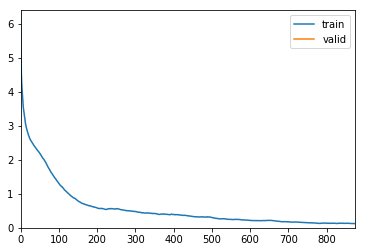

In [24]:
learner.fit_one_cycle(1, max_lr=max_lr, wd=wd)


จะเห็นว่า Converge ได้อย่างรวดเร็ว ได้ Accuracy พอ ๆ กัน

# 7. สรุป


* เราได้เรียนรู้วิธี LSUV Initialization ที่เรียบง่าย ใช้งานได้จริง ไม่ต้องคำนวนสูตรคณิตศาสตร์ซับซ้อน
* ไม่ว่าต่อไปโมเดลของเราจะเพิ่มความซับซ้อนขึ้นแค่ไหน เราสามารถ Initialize ให้ Mean=0, Std=1 ได้ด้วยวิธี LSUV นี้
* การ Initialization โมเดลที่ดีช่วยให้ เราเทรนโมเดลได้เร็วขึ้น โมเดล Converge เร็วขึ้น

# Credit

* https://course.fast.ai/videos/?lesson=11
* http://yann.lecun.com/exdb/mnist/
* https://www.bualabs.com/archives/509/mnist-fastai-resnet18-image-classification-ep-3/
* https://arxiv.org/abs/1511.06422
* https://pytorch.org/docs/stable/_modules/torch/nn/init.html